In [2]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

### Problem Deutscha dla jedno-qbitowej funkcji
Problemu Deutscha polega na stwierdzeniu czy zadana bramka realizuje funkcję zmienną czy stałą. Rozwiązując problem klasycznie trzeba sprawdzić wartość zwracaną dla każdego argumentu i na tej podstawie ocenić charakter funkcji. Układ kwantowy wystarczy uruchomić jednokrotnie, aby uzyskać odpowiedź.

Jedno-qbitowe bramki obliczeniowe Uf gdzie q0 stanowi wejście, a q1 wyjście. U_f0 i U_f3 są stałe, a U_f1 i U_f2 zmienne. 

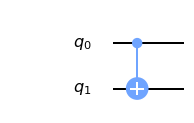

In [3]:
U_f1 = QuantumCircuit(2)
U_f1.cx(0,1)
U_f1.draw()

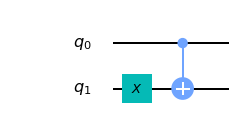

In [4]:
U_f2 = QuantumCircuit(2)
U_f2.x(1)
U_f2.cx(0,1)
U_f2.draw()

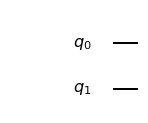

In [6]:
U_f0 = QuantumCircuit(2)
U_f0.draw()

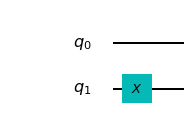

In [7]:
U_f3 = QuantumCircuit(2)
U_f3.x(1)
U_f3.draw()

Obkładając bramkę Hadamardami i podając |10> na wejście układu oczekujemy |1> na rejestrze wejściowym - q0 w przypadku gdy bramka realizowała funkcję zmienną i |0> gdy funkcję stałą  

In [8]:
def test_cuircut(Uf):
    hadamards = QuantumCircuit(2)
    hadamards.h(0)
    hadamards.h(1)

    zero_one = QuantumCircuit(2)
    zero_one.x(1)
    measure = QuantumCircuit(2,1)
    measure.barrier(range(1))
    measure.measure(range(1),range(1))
    
    return zero_one + hadamards + Uf + hadamards + measure


In [13]:
def simulate_quasm(qc):
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=1024)
    result = job.result()
    return result.get_counts(qc)

def simulate_melbourne(qc):
    backend = provider.get_backend('ibmq_16_melbourne')
    job = execute(qc, backend=backend)
    result = job.result()
    return result.get_counts(qc)

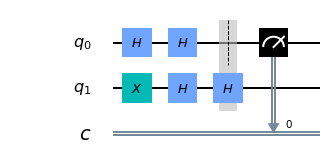

In [9]:
U_f0_test = test_cuircut(U_f0)
U_f0_test.draw()

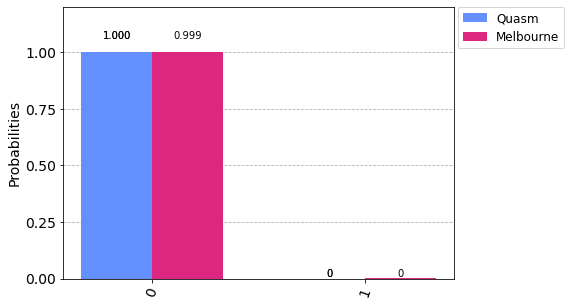

In [14]:
plot_histogram([simulate_quasm(U_f0_test), simulate_melbourne(U_f0_test)], legend=['Quasm', 'Melbourne'])

Na q0 (qubicie wejściowym) pojawiło się |0> czyli wynikiem testu jest funkcja stała co jest zgodne z prawdą, bo U_f0 realizuje funkcję stałą 0. Układ testowy korzysta z małej liczby bramek stąd odpowiedź komputera Melbourne jest wysoce zgodna z teoretyczą.

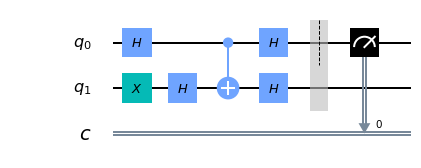

In [10]:
U_f1_test = test_cuircut(U_f1)
U_f1_test.draw()

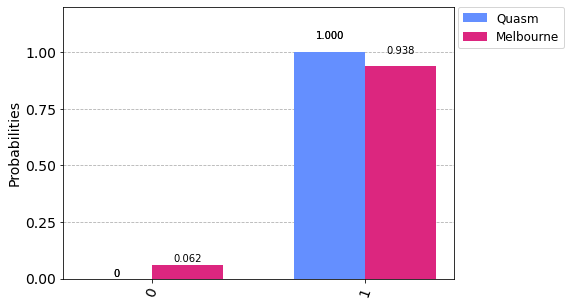

In [15]:
plot_histogram([simulate_quasm(U_f1_test), simulate_melbourne(U_f1_test)], legend=['Quasm', 'Melbourne'])

Test zwrócił |1> czyli, ocenił, że testowana funkcja jest zmienna co jest zgodne z prawdą. Bramek w układzie jest już więcej, ale i tak odpowiedź rzeczywistego komputera jest niezła.

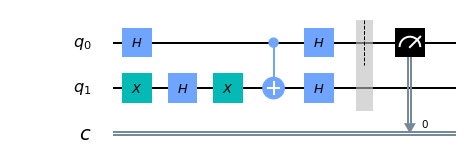

In [11]:
U_f2_test = test_cuircut(U_f2)
U_f2_test.draw()

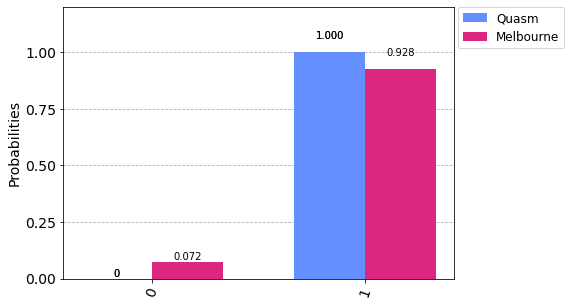

In [16]:
plot_histogram([simulate_quasm(U_f2_test), simulate_melbourne(U_f2_test)], legend=['Quasm', 'Melbourne'])

In [ ]:
Testowana funkcja została poprawnie zaakasyfikowana jako zmienna.

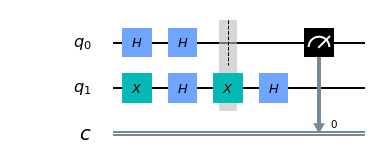

In [12]:
U_f3_test = test_cuircut(U_f3)
U_f3_test.draw()

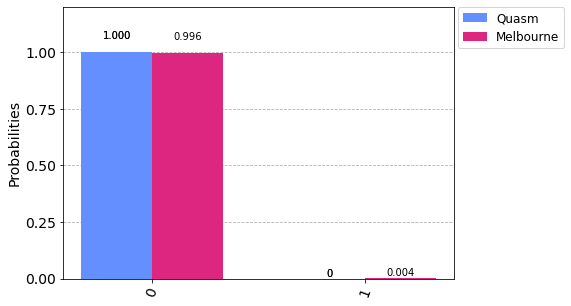

In [17]:
plot_histogram([simulate_quasm(U_f3_test), simulate_melbourne(U_f3_test)], legend=['Quasm', 'Melbourne'])

Testowana funkcja zgodnie z prawdą została zaklasyfikowana jako stała.

### Problemu Bernsteina-Vaziraniego
Problem Bernsteina-Vaziraniego polega na znalezieniu parametru a zaszytego w funkcji która mnoży odpowiadające bity argumentu i parametru, a następnie xoruje sąsiadujące bity wyniku od lewj do prawej.

Poniżej zaimplementowana jest bramka obliczeniowa Uf. Bity od q0 do q3 stanowią rejestr wejściowy, a q4 wyjściowy. Parametr a jest zakodowany jako bity kontrolne bramek CNOT i w tym wypadku wynosi 13.

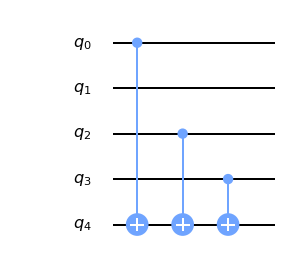

In [28]:
f = QuantumCircuit(5)
f.cx(0,4)
f.cx(2,4)
f.cx(3,4)
f.draw()

Klasycznie aby uzyskać informację o parametrze funkcji trzeba ją wywołać z maskami |0001>, |0010>, |0100> i |1000>. Dla każdej maski jeśli na qubicie wyjściowym (q4) pojawi się |1> znaczy to, że bit 'wchodzi w skład' parametru:

In [39]:
a=0
for i in range(4):
    test = QuantumCircuit(5,1)
    test.x(i)
    test += f
    test.barrier([4])
    test.measure([4],[0])
    results = simulate_quasm(test)
    if('1' in results and results['1'] == 1024):
        a += 1 << i
    
print(a)

13


Rozwiązanie kwantowe pozwala na odczytanie parametru a po jednokrotnym uruchomieniu układu. Bramkę obkładam Hadamardami i podając |1> na rejestr wyjściowy q5 na rejestrze wejściowym (q0 - q4) powinien pojawić się parametr funkcji.

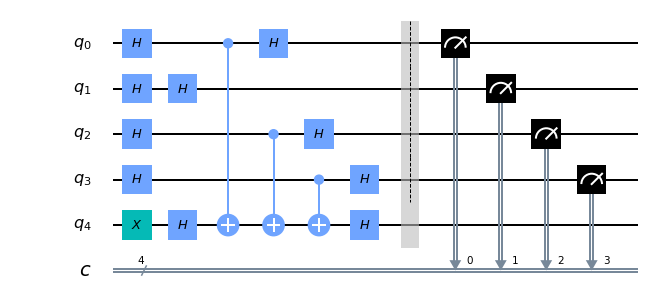

In [40]:
hadamards = QuantumCircuit(5)
hadamards.h(0)
hadamards.h(1)
hadamards.h(2)
hadamards.h(3)
hadamards.h(4)

f_test = QuantumCircuit(5,4)
f_test.x(4)
f_test = f_test + hadamards + f + hadamards
f_test.barrier(range(4))
f_test.measure(range(4),range(4))
f_test.draw()

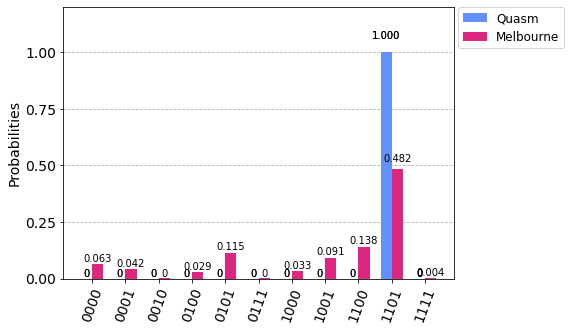

In [42]:
plot_histogram([simulate_quasm(f_test), simulate_melbourne(f_test)], legend=['Quasm', 'Melbourne'])

Zarówno symulator teoretyczny jak i komputer kwantowy poprawnie wskazały na paramter = 13. Układ testowy składa się z większej liczby bramek niż w problemie Deutscha stąd błąd komputera kwantowego jest dużo większy. 13 zostało wskazane z  prawdopodobieństwem ~50% i jest to ewidentnie najbardziej prawdopodobna wartość parametru według Melbourne (kolejna najbardziej prawdopodobna ma ~13%).